In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from scipy.ndimage import uniform_filter1d
import builtins
import os

2025-01-18 17:40:34.121854: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set intra-op threads (for parallelizing within a single operation)
tf.config.threading.set_intra_op_parallelism_threads(24)  # Use all 24 threads

# Set inter-op threads (for parallelizing across independent operations)
tf.config.threading.set_inter_op_parallelism_threads(2)   # Adjust based on your workload

# Verify the settings
print("Intra-op threads:", tf.config.threading.get_intra_op_parallelism_threads())
print("Inter-op threads:", tf.config.threading.get_inter_op_parallelism_threads())

Intra-op threads: 24
Inter-op threads: 2


In [3]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'  # Enable oneDNN optimizations

In [4]:
# Output path
output_path = '../export/mlp/'

In [5]:
%run "../helpers/data-processing.ipynb"

Missing values in the dataset


,Column,Missing Count,Missing Percentage,Action
0,date,0,0.000000,No Missing Values
1,open,0,0.000000,No Missing Values
2,high,0,0.000000,No Missing Values
3,low,0,0.000000,No Missing Values
4,close,0,0.000000,No Missing Values
5,Volume USDT,0,0.000000,No Missing Values
6,tradecount,0,0.000000,No Missing Values
7,ema_5,0,0.000000,No Missing Values
8,ema_15,0,0.000000,No Missing Values
9,ema_30,0,0.000000,No Missing Values


Analyzing feature correlations...

The following features were dropped due to high correlation (threshold: 90%):
- ema_5
- high
- ema_100
- close
- HMA
- Z-Score
- ema_60
- ema_15
- WMA
- MACD_Hist
- ema_30
- ema_200
- open
- KAMA
- low

Performing feature selection using RandomForestClassifier...

Cross-validation accuracy scores: [0.99994 1.      1.     ]

Mean accuracy: 1.0000

The following features were selected based on feature importance:
- date
- price
- Volume USDT
- tradecount
- MACD
- MACD_Signal
- ATR
- CMO
- QStick
- price_change_ratio
- high_low_spread

Feature selection process completed.

Shape of X: (1997210, 11)


,date,price,Volume USDT,tradecount,MACD,MACD_Signal,ATR,CMO,QStick,price_change_ratio,high_low_spread
0,1.577837e+09,7180.720,509146.0,140.0,0.728704,-0.152219,4.684925,4.193879,0.120,0.000000,3.69
1,1.577837e+09,7178.470,713540.0,148.0,0.736887,-0.182091,4.698380,0.859360,0.528,-0.000313,3.76
2,1.577837e+09,7179.440,497793.0,104.0,0.846578,-0.117923,4.609025,11.466626,0.493,0.000135,5.60
3,1.577837e+09,7177.175,698627.0,193.0,0.650488,-0.343494,4.398181,-7.962104,-0.425,-0.000315,6.16
4,1.577837e+09,7175.160,241980.0,124.0,0.987398,-0.092457,4.262656,-6.795307,-0.131,-0.000281,3.86
...,...,...,...,...,...,...,...,...,...,...,...
1997205,1.698019e+09,29966.285,482950.0,635.0,-4056.925846,-1909.922487,926.278065,-97.689989,13.189,-0.000401,5.00
1997206,1.698019e+09,29970.500,169682.0,450.0,-3657.565528,-1988.042791,996.882531,-97.688910,24.399,0.000141,5.83
1997207,1.698019e+09,29975.100,111271.0,303.0,-3095.229187,-1922.717147,1072.856572,-97.688328,32.045,0.000153,3.40
1997208,1.698019e+09,29980.890,169741.0,631.0,-2332.807178,-1640.974425,1154.492462,-97.687019,22.669,0.000193,8.21



Shape of y: (1997210,)


0    1
1    0
2    1
3    0
4    0
Name: price_direction, dtype: int64

In [6]:
def trading_loss(y_true, y_pred):
    """
    Custom loss function to penalize frequent trades.
    Penalizes predictions close to 0.5 (indicating uncertainty).
    """
    # Binary crossentropy loss
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Trade penalty: higher penalty for predictions close to 0.5
    trade_penalty = tf.abs(y_pred - 0.5)  # Confidence score: smaller for values near 0.5
    penalty_factor = 0.1  # Adjust the trade penalty factor (tune as needed)
    total_loss = bce_loss + penalty_factor * (1 - trade_penalty)  # Higher penalty near 0.5

    return tf.reduce_mean(total_loss)

In [7]:
# Exclude date feature
X = X[:, 1:]

In [8]:
# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Reserve the last 15% as the test set
test_size = int(0.15 * len(X_scaled))
X_test, y_test = X_scaled[-test_size:], y[-test_size:]
X_train_val, y_train_val = X_scaled[:-test_size], y[:-test_size]

In [10]:
# Time-based split using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Placeholder to store metrics for each split
split_metrics = []

for i, (train_idx, val_idx) in enumerate(tscv.split(X_train_val)):
    print(f"\nSplit {i + 1}/{tscv.n_splits}")

    # Split the data
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    # Balance the classes
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Build the MLP model (one model per split if necessary)
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        GaussianNoise(0.01),  # Add noise to the input layer
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=trading_loss,
        metrics=['accuracy']
    )

    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with class weights
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=128,
        class_weight=class_weight_dict,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy for Split {i + 1}: {val_accuracy:.4f}")
    print(f"Validation Loss for Split {i + 1}: {val_loss:.4f}")

    # Save metrics for analysis
    split_metrics.append({
        "split": i + 1,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    })

# Aggregate results across splits
mean_val_accuracy = np.mean([m["val_accuracy"] for m in split_metrics])
mean_val_loss = np.mean([m["val_loss"] for m in split_metrics])

print("\n--- Cross-Validation Results ---")
print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f}")
print(f"Mean Validation Loss: {mean_val_loss:.4f}")


Split 1/5
Epoch 1/10
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5590 - loss: 0.8542 - val_accuracy: 0.6810 - val_loss: 0.7203
Epoch 2/10
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6402 - loss: 0.7243 - val_accuracy: 0.7812 - val_loss: 0.7167
Epoch 3/10
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6435 - loss: 0.7131 - val_accuracy: 0.5586 - val_loss: 0.7369
Epoch 4/10
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6446 - loss: 0.7089 - val_accuracy: 0.5140 - val_loss: 0.7529
Epoch 5/10
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6437 - loss: 0.7086 - val_accuracy: 0.5282 - val_loss: 0.7622
Epoch 6/10
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6448 - loss: 0.7068 - val_accuracy: 0.5938 - val_loss: 0.7207
Epoch 7/10
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6438 - loss: 0.7063 - val_accuracy: 0.5448 - val_loss: 0.7570
Validation Accuracy for Split 1: 0.7812
Validation Loss for Split 1: 0.7167

Sp

In [11]:
# Prepare test dataset and evaluation variables
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
X_test_evaluate = X_test  # Assign X_test for evaluation
y_test_evaluate = y_test  # Assign y_test for evaluation

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.75


In [14]:
# Predict probabilities for the entire test set
predicted_probas = model.predict(X_test).flatten()

9362/9362 ━━━━━━━━━━━━━━━━━━━━ 3s 284us/step


In [15]:
# Smooth predicted probabilities
smoothed_probas = uniform_filter1d(predicted_probas, size=5)

In [16]:
print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (1414691, 10) (1414691,)
Validation set size: (282938, 10) (282938,)
Test set size: (299581, 10) (299581,)


In [17]:
# Slice prices to match each split
prices_train = prices[:len(X_train)]  # First 70% of prices for train
prices_val = prices[len(X_train):len(X_train) + len(X_val)]  # Next 15% for validation
prices_test = prices[len(X_train) + len(X_val):]  # Remaining 15% for test

In [18]:
# Adjusted thresholds
buy_threshold = 0.8
sell_threshold = 0.2

# # Adjust thresholds based on validation data
# buy_threshold = np.percentile(predicted_probas, 90)  # Top 10% probabilities for buys
# sell_threshold = np.percentile(predicted_probas, 10)  # Bottom 10% probabilities for sells
# 
# print(f"Dynamic Buy Threshold: {buy_threshold}")
# print(f"Dynamic Sell Threshold: {sell_threshold}")

In [19]:
# Maximum fraction of the portfolio to trade
max_trade_fraction = 0.1  # up to 10% in the most confident case

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - accuracy: 0.7755 - loss: 0.7077
Test Accuracy: 74.81%
9362/9362 ━━━━━━━━━━━━━━━━━━━━ 3s 284us/step
Confusion Matrix:
Predicted       0     1
Actual                 
0          146603     0
1          151830  1148


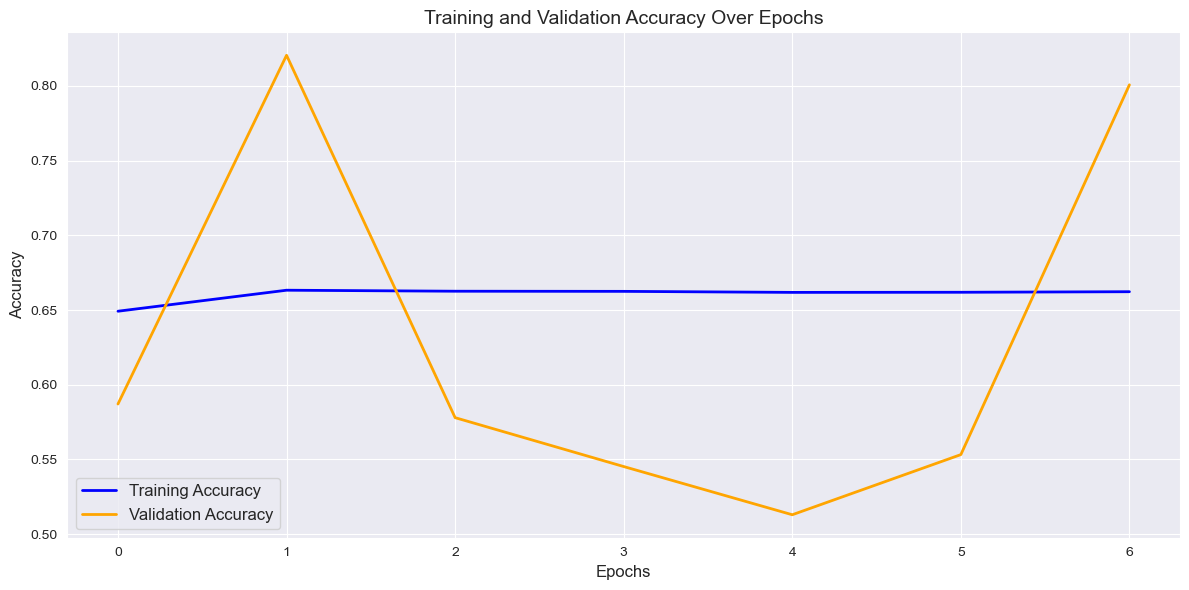

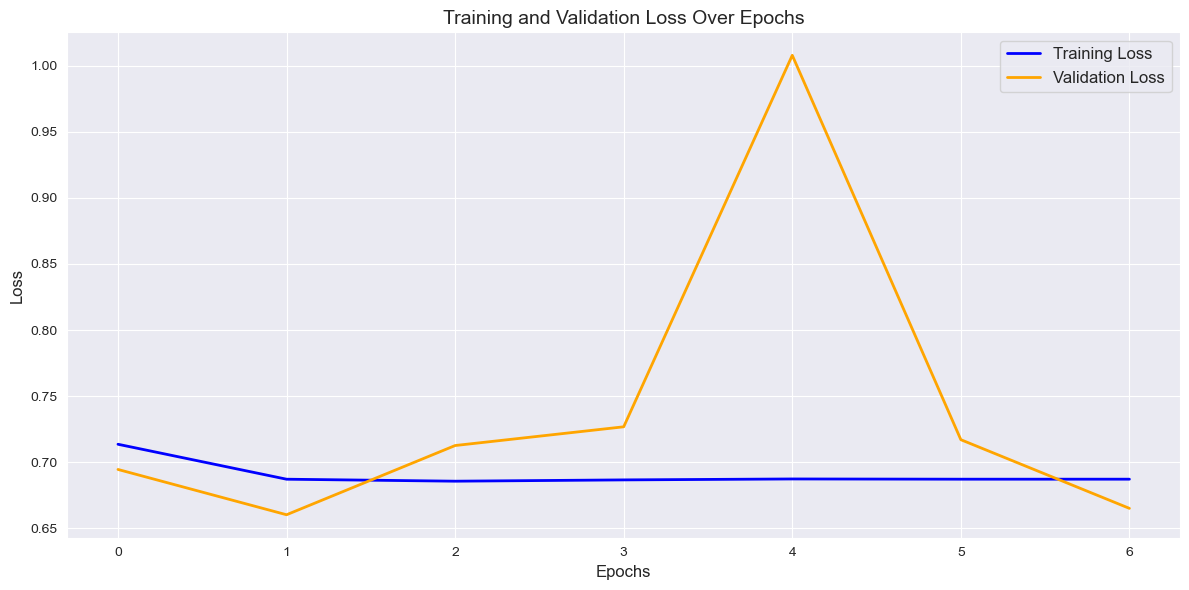

In [20]:
%run "../helpers/evaluate_tf.ipynb"

In [21]:
# Starting portfolio values
usd_balance = 10000.0  # Starting USD balance
btc_balance = 0.0      # Starting BTC balance
buy_fee = 0.0025  # 0.25% buy fee
sell_fee = 0.004  # 0.40% sell fee

# Track balances and actions
usd_balances = []
btc_balances = []
actions = []
trade_percentages = []

In [22]:
# Loop over prices_test and use precomputed probabilities
for t in range(len(prices_test)):
    # Default action is 'None'
    action = 'None'
    trade_percentage = 0.0

    # Use precomputed probability
    predicted_proba = smoothed_probas[t]

    # Compute confidence: ranges from 0 (proba = 0.5) to 0.5 (proba = 0 or 1)
    confidence = abs(predicted_proba - 0.5)  # 0.0 → not sure, 0.5 → extremely sure

    # Turn confidence into a fraction of max_trade_fraction
    # e.g. if confidence=0.4, fraction_to_trade=0.2*(0.4/0.5)=0.16 (i.e. 16% of USD)
    fraction_to_trade = max_trade_fraction * (confidence / 0.5)

    # Decide action based on thresholds
    if predicted_proba > buy_threshold and usd_balance > 1e-3:
        # Buy if proba > buy_threshold. The fraction_to_trade goes from 0 to max_trade_fraction (0 to 20%)
        usd_spent = fraction_to_trade * usd_balance
        # Convert to BTC, minus the buy fee
        btc_bought = (usd_spent * (1 - buy_fee)) / prices_test[t]
        usd_balance -= usd_spent
        btc_balance += btc_bought
        action = 'Buy'
        trade_percentage = fraction_to_trade  # record how much fraction we traded

    elif predicted_proba < sell_threshold and btc_balance > 1e-6:
        # Sell if proba < sell_threshold. fraction_to_trade is again 0 to 20% based on confidence
        btc_to_sell = fraction_to_trade * btc_balance
        usd_gained = btc_to_sell * prices_test[t] * (1 - sell_fee)
        btc_balance -= btc_to_sell
        usd_balance += usd_gained
        action = 'Sell'
        trade_percentage = fraction_to_trade  # record how much fraction we traded

    # Record balances and actions
    usd_balances.append(usd_balance)
    btc_balances.append(btc_balance)
    actions.append(action)
    trade_percentages.append(trade_percentage)

In [23]:
# Final portfolio status
final_btc_price = prices_test[-1]
remaining_btc_value = btc_balance * final_btc_price
total_portfolio_value = usd_balance + remaining_btc_value
profit_loss = ((total_portfolio_value - 10000) / 10000) * 100

print("Final Portfolio Status:")
print(f"  USD Balance: ${usd_balance:.2f}")
print(f"  BTC Balance: {btc_balance:.6f} BTC")
print(f"  BTC Value (in USD at last price): ${remaining_btc_value:.2f}")
print(f"  Total Portfolio Value (USD): ${total_portfolio_value:.2f}")
print(f"  Profit/Loss: {profit_loss:.2f}%")

Final Portfolio Status:
  USD Balance: $9008.81
  BTC Balance: 0.065726 BTC
  BTC Value (in USD at last price): $1971.03
  Total Portfolio Value (USD): $10979.83
  Profit/Loss: 9.80%


In [24]:
builtins.data = pd.DataFrame({
    'prices': prices_test,
    'USD_Balance': usd_balances,
    'BTC_Balance': btc_balances,
    'Action': actions,
    'Trade_Percentage': trade_percentages,
})

Trading Log:


,prices,USD_Balance,BTC_Balance,Action,Trade_Percentage,Total_Capital
0,27409.745,10000.000000,0.000000,None,0.000000,10000.000000
1,27419.005,10000.000000,0.000000,None,0.000000,10000.000000
2,27430.025,10000.000000,0.000000,None,0.000000,10000.000000
3,27410.065,10000.000000,0.000000,None,0.000000,10000.000000
4,27394.345,10000.000000,0.000000,None,0.000000,10000.000000
...,...,...,...,...,...,...
299576,29966.285,8729.248036,0.075090,Sell,0.070282,10979.423136
299577,29970.500,8879.925510,0.070043,Sell,0.067222,10979.134511
299578,29975.100,9008.806501,0.065726,Sell,0.061632,10978.939112
299579,29980.890,9008.806501,0.065726,None,0.000000,10979.319664


Processing Rows: 100%|██████████| 299581/299581 [00:05<00:00, 52002.61rows/s]


Final Portfolio Status:
  USD Balance: $9008.81
  BTC Balance: 0.065726 BTC
  BTC Value (in USD at last price): $1971.03
  Total Portfolio Value (USD): $10979.83
  Profit/Loss: 9.80%
  Total Trades Executed: 408
    Buy Trades: 135
    Sell Trades: 273


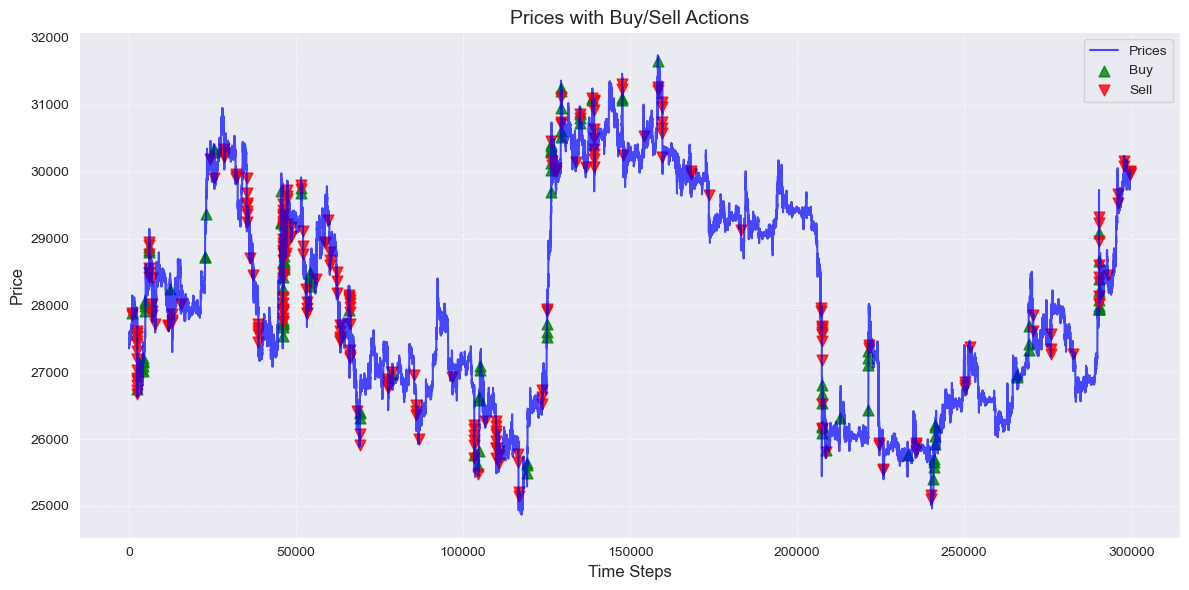

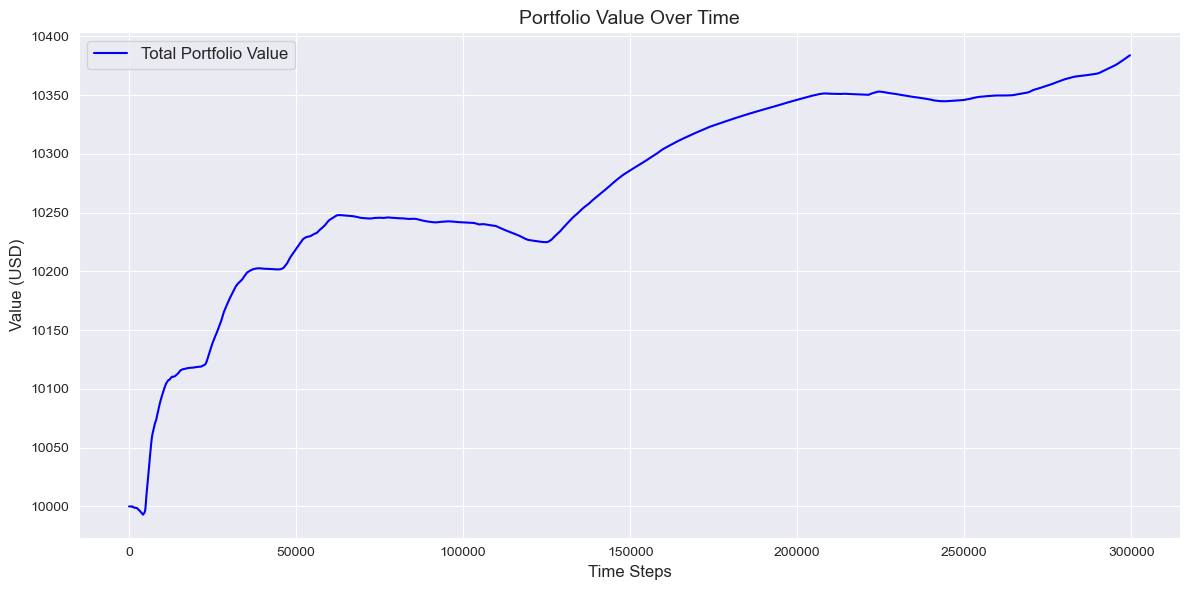

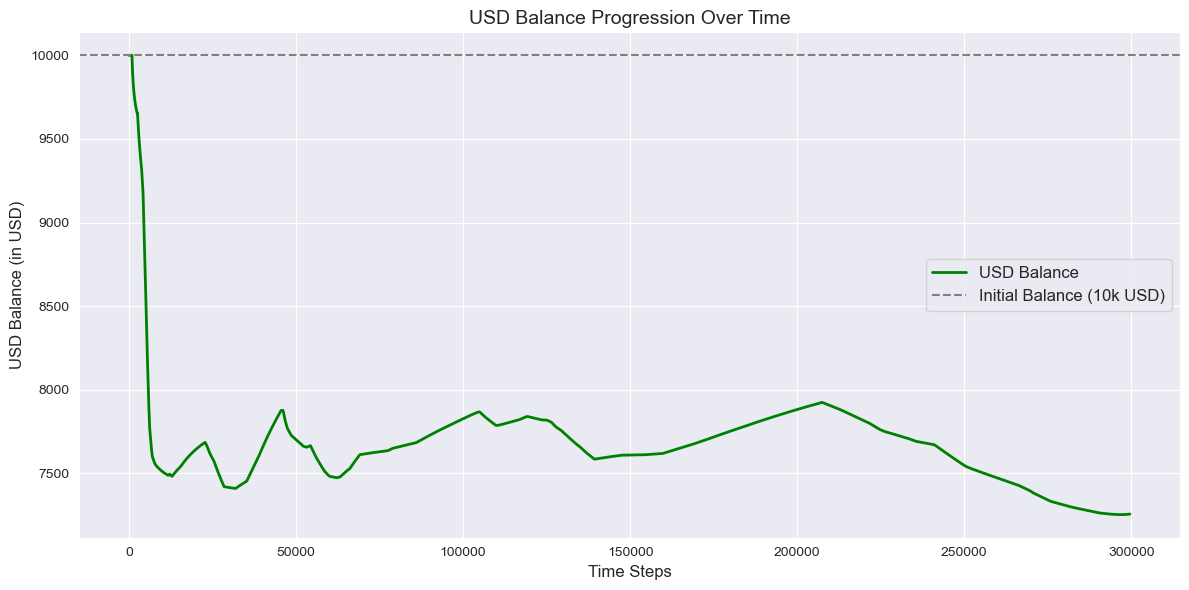

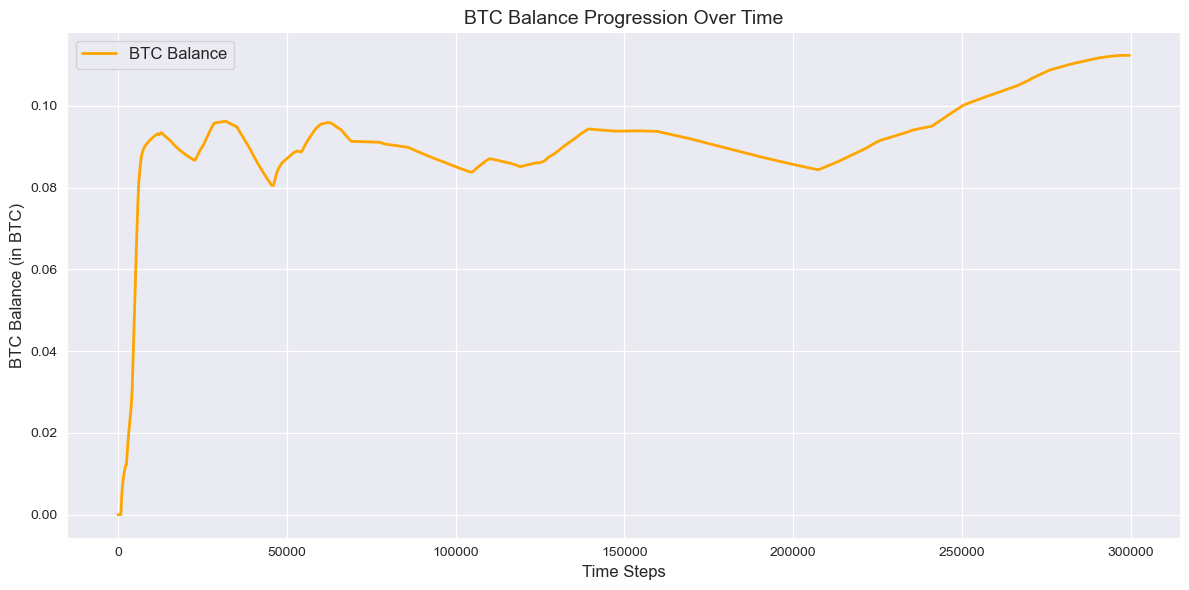

In [25]:
%run "../helpers/trades.ipynb"

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(42)

# Placeholder for your dataset (X, y)
# Replace these with your actual input_data
# X_train, X_val, X_test, y_train, y_val, y_test should already be defined

# Test set evaluation
def evaluate_on_test_set(model, X_test, y_test):
    """Evaluate the model on the test set and return metrics."""
    y_pred = model.predict(X_test)
    y_test = np.array(y_test).astype(int)
    y_pred = (y_pred > 0.5).astype(int).flatten()

    test_accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return {
        'accuracy': test_accuracy,
        'report': report,
        'confusion_matrix': cm
    }

# Confidence analysis
def analyze_prediction_confidence(model, X_test, y_test):
    """Analyze prediction confidence and return plots."""
    try:
        predicted_proba = model.predict_proba(X_test)
        confidence_scores = np.max(predicted_proba, axis=1)

        plt.figure(figsize=(10, 6))
        plt.hist(confidence_scores, bins=20, color='blue', alpha=0.7, edgecolor='black')
        plt.title("Prediction Confidence Distribution")
        plt.xlabel("Confidence")
        plt.ylabel("Frequency")
        plt.grid(alpha=0.6)
        plt.show()

        correct_predictions = (model.predict(X_test) > 0.5).astype(int).flatten() == y_test
        plt.figure(figsize=(10, 6))
        plt.scatter(confidence_scores, correct_predictions, alpha=0.3, color='orange')
        plt.title("Confidence vs Correctness")
        plt.xlabel("Confidence")
        plt.ylabel("Correct Prediction")
        plt.grid(alpha=0.6)
        plt.show()
    except AttributeError:
        print("Model does not have a predict_proba method.")

# Data leakage check
def check_data_leakage(X_train, X_test):
    """Check for input_data leakage between training and test sets."""
    if not isinstance(X_train, (pd.DataFrame, np.ndarray)) or not isinstance(X_test, (pd.DataFrame, np.ndarray)):
        print("X_train and X_test should be DataFrames or NumPy arrays for leakage check.")
        return

    # Convert to DataFrames if they are NumPy arrays
    if isinstance(X_train, np.ndarray):
        X_train = pd.DataFrame(X_train)
    if isinstance(X_test, np.ndarray):
        X_test = pd.DataFrame(X_test)

    common_features = set(X_train.columns) & set(X_test.columns)
    if len(common_features) != X_train.shape[1]:
        print("Warning: Feature mismatch between train and test sets.")
    else:
        print("No apparent input_data leakage detected in features.")

# Evaluate robustness with noisy input_data
def evaluate_with_noise(model, X_test, y_test, noise_level=0.01):
    """Evaluate model's robustness with noisy input_data and return accuracy."""
    if not isinstance(X_test, np.ndarray):
        try:
            X_test = X_test.values  # Convert to numpy array if possible
        except AttributeError:
            print("X_test cannot be converted to a numpy array.")
            return None
    X_noisy = X_test + noise_level * np.random.normal(size=X_test.shape)
    y_pred_noisy = (model.predict(X_noisy) > 0.5).astype(int).flatten()
    noisy_accuracy = accuracy_score(y_test, y_pred_noisy)
    return noisy_accuracy

# Run all checks
def check_model_overfitting(model, X_train, X_val, X_test, y_train, y_val, y_test, noise_level=0.01):
    """Run all evaluations to check for model overfitting."""
    print("\n--- Evaluating on Test Set ---")
    test_results = evaluate_on_test_set(model, X_test, y_test)
    print(f"Test Set Accuracy: {test_results['accuracy']}")
    print("Classification Report (Test Set):\n", test_results['report'])
    print("Confusion Matrix (Test Set):\n", test_results['confusion_matrix'])

    print("\n--- Analyzing Prediction Confidence ---")
    analyze_prediction_confidence(model, X_test, y_test)

    print("\n--- Checking for Data Leakage ---")
    check_data_leakage(X_train, X_test)

    print("\n--- Evaluating with Noise ---")
    noisy_accuracy = evaluate_with_noise(model, X_test, y_test, noise_level)
    print(f"Accuracy with {noise_level * 100:.1f}% Noise:", noisy_accuracy)

# Usage example (replace `model` with your trained model)
noise_level = 0.01  # Define the noise level
check_model_overfitting(model, X_train, X_val, X_test, y_train, y_val, y_test, noise_level)


--- Evaluating on Test Set ---
9362/9362 ━━━━━━━━━━━━━━━━━━━━ 3s 280us/step
Test Set Accuracy: 0.7480948391253117
Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.67      0.94      0.78    146603
           1       0.91      0.56      0.70    152978

    accuracy                           0.75    299581
   macro avg       0.79      0.75      0.74    299581
weighted avg       0.79      0.75      0.74    299581

Confusion Matrix (Test Set):
 [[137726   8877]
 [ 66589  86389]]

--- Analyzing Prediction Confidence ---
Model does not have a predict_proba method.

--- Checking for Data Leakage ---
No apparent input_data leakage detected in features.

--- Evaluating with Noise ---
9362/9362 ━━━━━━━━━━━━━━━━━━━━ 3s 278us/step
Accuracy with 1.0% Noise: 0.5836718617001746


Data Leakage Check

Data alignment check passed.
Correlation between predictions and future price changes:
                     predictions  future_price_change
predictions             1.000000             0.250137
future_price_change     0.250137             1.000000


Feature Importance Analysis

Feature Importances:
               Feature  Importance
9   price_change_ratio    0.941433
8               QStick    0.022292
7                  CMO    0.009655
5          MACD_Signal    0.008473
10     high_low_spread    0.005913
6                  ATR    0.002730
4                 MACD    0.002276
2          Volume USDT    0.002252
3           tradecount    0.001853
0                 date    0.001638
1                price    0.001486
Permutation Importances:
               Feature  Importance
9   price_change_ratio    0.499862
8               QStick    0.000049
7                  CMO    0.000046
5          MACD_Signal    0.000040
10     high_low_spread    0.000036
4                 MACD  

Processing Rows: 100%|██████████| 299581/299581 [00:05<00:00, 51152.92rows/s]



Sensitivity Analysis



,Initial USD Balance,Initial BTC Balance,Maker Fee,Taker Fee,Final USD Balance,Final BTC Balance,Total Portfolio Value (USD),Profit/Loss (%),Buy Trades,Sell Trades
0,10000.0,0.0,0.0025,0.0040,9008.806501,0.065726,10979.834953,9.798350,135,273
1,10000.0,0.0,0.0015,0.0030,9110.116964,0.066423,11102.043387,11.020434,135,273
2,10000.0,0.0,0.0050,0.0075,8711.450424,0.063710,10622.026395,6.220264,135,273
3,20000.0,0.0,0.0025,0.0040,18017.613002,0.131451,21959.669905,9.798350,135,273
4,20000.0,0.0,0.0015,0.0030,18220.233928,0.132845,22204.086775,11.020434,135,273
5,20000.0,0.0,0.0050,0.0075,17422.900848,0.127420,21244.052790,6.220264,135,273
6,5000.0,0.5,0.0025,0.0040,16880.086501,0.123152,20573.265032,311.465301,135,273
7,5000.0,0.5,0.0015,0.0030,17076.111418,0.124503,20809.801959,316.196039,135,273
8,5000.0,0.5,0.0050,0.0075,16299.115393,0.119201,19873.801203,297.476024,135,273


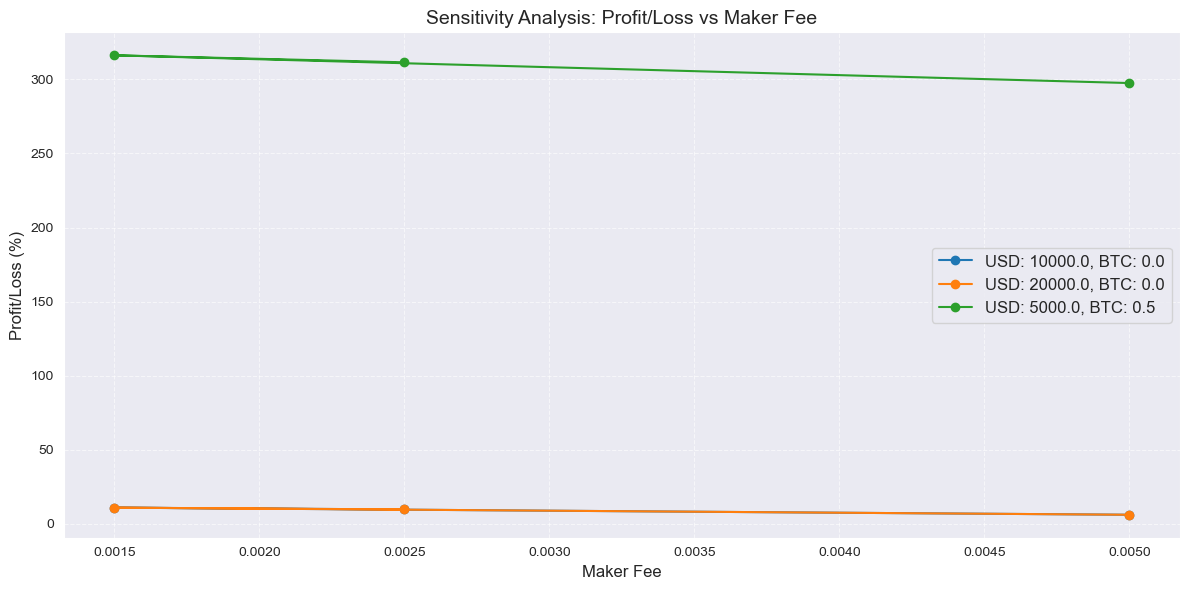

In [27]:
%run "../helpers/testing.ipynb"